In [60]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import random
from pyHalo.preset_models import CDM

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import strong_lens
from mejiro.utils import util

In [61]:
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)
lens = random.choice(lens_list)

In [62]:
pipeline_params = util.hydra_to_dict(config.pipeline)
subhalo_cone = pipeline_params['subhalo_cone']
los_normalization = pipeline_params['los_normalization']

# circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)

# randomly generate CDM subhalos
log_m_host = np.log10(lens.main_halo_mass)
# TODO calculate r_tidal: the core radius of the host halo in units of the host halo scale radius. Subhalos are distributed in 3D with a cored NFW profile with this core radius; by default, it's 0.25
r_tidal = 0.5
sigma_sub = 0.055
cdm_realization = CDM(z_lens,
                      z_source,
                      sigma_sub=sigma_sub,
                      log_mlow=6.,
                      log_mhigh=10.,
                      log_m_host=log_m_host,
                      r_tidal=r_tidal,
                      cone_opening_angle_arcsec=subhalo_cone,
                      LOS_normalization=los_normalization)

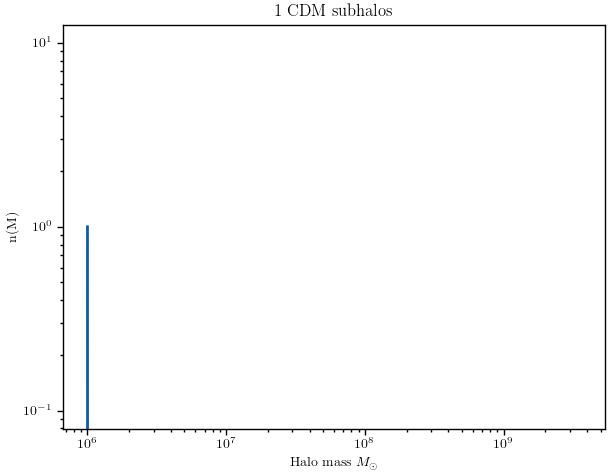

In [63]:
cdm_halo_masses = [halo.mass for halo in cdm_realization.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass ' + r'$M_{\odot}$')
ax.set_ylabel('n(M)')
ax.set_title(f'{len(cdm_halo_masses)} CDM subhalos')
plt.show()

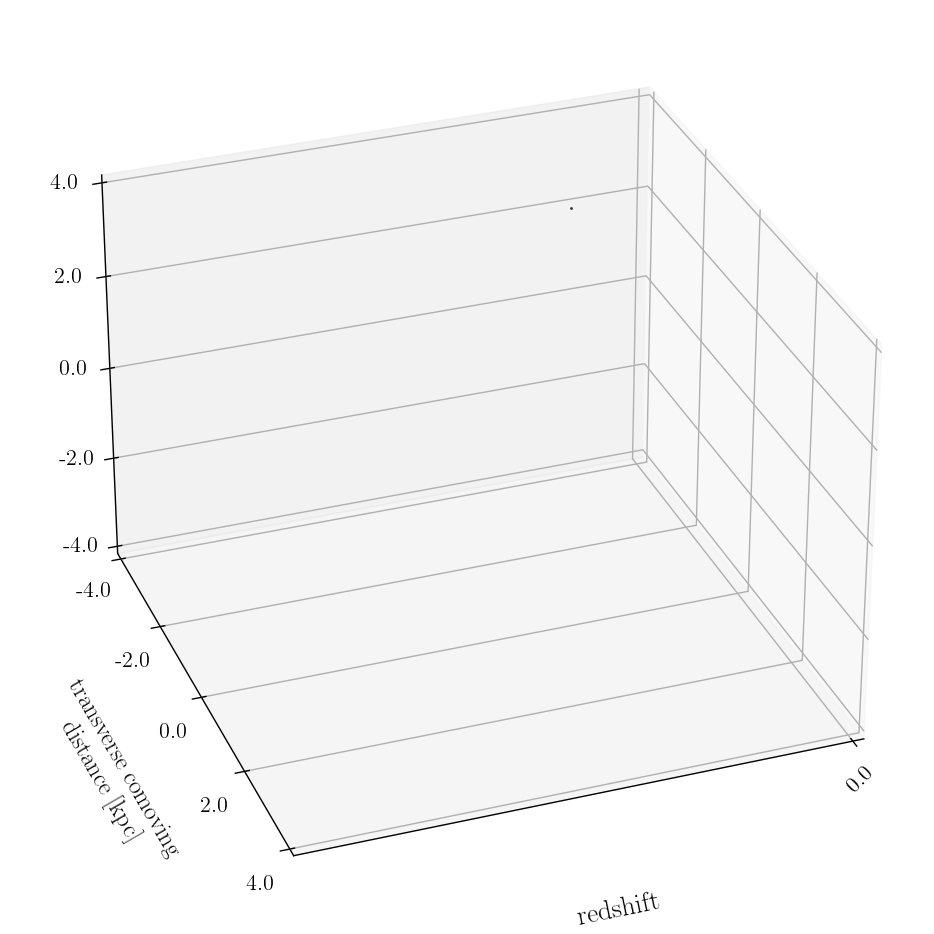

In [64]:
fig = plt.figure(2)
fig.set_size_inches(14, 12)
ax = plt.subplot(111, projection='3d')
cdm_realization.plot(ax)

In [65]:
original_einstein_radius = lens.get_einstein_radius()
print(f'Original Einstein radius: {original_einstein_radius:.5f} arcsec')

Original Einstein radius: 0.60372 arcsec


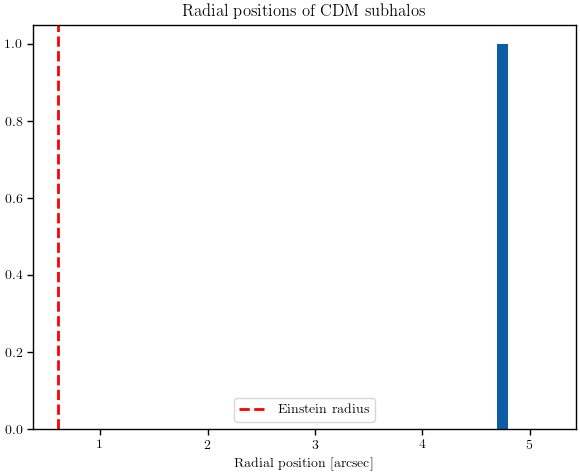

In [66]:
radii = [np.sqrt(halo.x ** 2 + halo.y ** 2) for halo in cdm_realization.halos]

plt.hist(radii)
plt.axvline(original_einstein_radius, color='r', linestyle='--', label='Einstein radius')
plt.xlabel('Radial position [arcsec]')
plt.title('Radial positions of CDM subhalos')
plt.legend()
plt.show()

In [67]:
total_mass_subhalos_within_einstein_radius = sum(
    [halo.mass for halo in cdm_realization.halos if np.sqrt(halo.x ** 2 + halo.y ** 2) < original_einstein_radius])
print(f'Total mass of CDM halos within Einstein radius: {total_mass_subhalos_within_einstein_radius:.5e} M_Sun')

Total mass of CDM halos within Einstein radius: 0.00000e+00 M_Sun


In [68]:
total_subhalo_mass = sum([halo.mass for halo in cdm_realization.halos])
print(f'Total mass of CDM halos: {total_subhalo_mass:.2e} M_Sun')

print(
    f'Percentage of total subhalo mass within Einstein radius: {total_mass_subhalos_within_einstein_radius / total_subhalo_mass * 100:.2f}%')

Total mass of CDM halos: 1.29e+06 M_Sun
Percentage of total subhalo mass within Einstein radius: 0.00%


In [69]:
# convert original Einstein radius to effective lensing mass
effective_lensing_mass = strong_lens.einstein_radius_to_mass(original_einstein_radius, lens.d_l, lens.d_s, lens.d_ls)
print(f'Effective lensing mass: {effective_lensing_mass:.5e} M_Sun')

Effective lensing mass: 9.10727e+09 M_Sun


In [70]:
adjusted_lensing_mass = effective_lensing_mass - total_mass_subhalos_within_einstein_radius
print(f'Adjusted lensing mass: {adjusted_lensing_mass:.5e} M_Sun')

Adjusted lensing mass: 9.10727e+09 M_Sun


In [71]:
percent_change_lensing_mass = (adjusted_lensing_mass - effective_lensing_mass) / effective_lensing_mass * 100
print(f'Percent change of lensing mass: {percent_change_lensing_mass:.2f}%')

Percent change of lensing mass: 0.00%


In [72]:
adjusted_einstein_radius = strong_lens.mass_to_einstein_radius(adjusted_lensing_mass, lens.d_l, lens.d_s, lens.d_ls)
print(f'Adjusted Einstein radius: {adjusted_einstein_radius:.5f} arcsec')

Adjusted Einstein radius: 0.60372 arcsec


In [73]:
percent_change_einstein_radius = (adjusted_einstein_radius - original_einstein_radius) / original_einstein_radius * 100
print(f'Percent change of Einstein radius: {percent_change_einstein_radius:.2f}%')

Percent change of Einstein radius: -0.00%
